In [ ]:
!pip install tensorflow-text --quiet
!pip install keras.metrics --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [ ]:
import numpy as np
import pandas as pd
import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, Dropout, RepeatVector, Dot, Concatenate, Bidirectional, Activation
from keras.models import Model
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
import torch

In [ ]:
en_file = r'/content/drive/MyDrive/Honours-DL/Translation/hi-ta/train.ta'
mr_file = r'/content/drive/MyDrive/Honours-DL/Translation/hi-ta/train.hi'

In [ ]:
with open(en_file, 'r', encoding='utf-8') as file:
    en_sentences = [line.strip() for line in file.readlines()[:-400000]]
with open(mr_file, 'r', encoding='utf-8') as file:
    mr_sentences = [line.strip() for line in file.readlines()[:-400000]]
en_sentences = [sentence.rstrip('\n') for sentence in en_sentences]
mr_sentences = [sentence.rstrip('\n') for sentence in mr_sentences]
print("Eng : Total", len(en_sentences))
print("Mar : Total ", len(mr_sentences))

Eng : Total 2101092
Mar : Total  2101092


In [ ]:
with open(en_file, 'r', encoding='utf-8') as file:
    en_sentences_test = [line.strip() for line in file.readlines()[-400000:]]
with open(mr_file, 'r', encoding='utf-8') as file:
    mr_sentences_test = [line.strip() for line in file.readlines()[-400000:]]
en_sentences_test = [sentence.rstrip('\n') for sentence in en_sentences_test]
mr_sentences_test = [sentence.rstrip('\n') for sentence in mr_sentences_test]
print("Eng : Total", len(en_sentences_test))
print("Mar : Total ", len(mr_sentences_test))

Eng : Total 400000
Mar : Total  400000


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")
model = model.cuda()

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
sample = ""
token_ids = tokenizer.encode(sample)
print(tokenizer.convert_ids_to_tokens(token_ids))

['</s>']


In [ ]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])  # Get full Vocab

In [ ]:
def encode_input_string(text, tokenizer, seq_len=25):
  input_ids = tokenizer.encode(
      text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )
  return input_ids[0]

def encode_target_string(text, tokenizer, seq_len=25):
  input_ids = tokenizer.encode(
      text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len
  )
  return input_ids[0]


In [ ]:
def format_data(data, tokenizer, seq_len=128):
  input_token_ids = encode_input_string(data['English'], tokenizer, seq_len=seq_len)
  target_token_ids = encode_target_string(data['Marathi'], tokenizer, seq_len=seq_len)

  return input_token_ids, target_token_ids

In [ ]:
import random

def transform_batch(batch, tokenizer, max_seq_len):

    inputs = []
    targets = []

    for translation_set in batch:
        input_sentence = translation_set[0]  # Assuming translation_set is a tuple (input_sentence, target_sentence)
        target_sentence = translation_set[1]

        formatted_data = format_data({"English": input_sentence, "Marathi": target_sentence}, tokenizer, max_seq_len)

        if formatted_data is None:
            continue

        input_ids, target_ids = formatted_data
        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()
    # batch_input_ids = torch.cat(inputs)
    # batch_target_ids = torch.cat(targets)

    return batch_input_ids, batch_target_ids

def get_data_generator(dataset, tokenizer, batch_size=32):
    dataset = list(zip(dataset["English"], dataset["Marathi"]))  # Assuming dataset is a DataFrame with 'English' and 'Marathi' columns
    random.shuffle(dataset)  # Shuffle the dataset

    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i + batch_size]
        yield transform_batch(raw_batch, tokenizer, 20)


In [ ]:
in_ids, out_ids = format_data({"English": "Today, ASEAN and India enjoy multi-faceted coo", "Marathi": "आज आसियान आणि भारत, आसियानचे राजनीतिक- सुरक्षा"}, tokenizer)

In [ ]:
lines = pd.DataFrame({"English": en_sentences, "Marathi": mr_sentences})
test_dataset = pd.DataFrame({"English": en_sentences_test, "Marathi": mr_sentences_test})

In [ ]:
data_gen = get_data_generator(lines, tokenizer, 8)
print(data_gen)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<generator object get_data_generator at 0x7bfdf82bd1c0>
Input shape: torch.Size([8, 20])
Output shape: torch.Size([8, 20])


In [ ]:
n_epochs = 5
batch_size = 128
print_freq = 100
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(lines) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)
model_path = (r"/content/drive/MyDrive/Honours-DL/Translation/hi-ta/finetuned-ta-hi.pt")

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
prev_test_loss = float('inf')

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(lines,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      if test_loss <= prev_test_loss:
        prev_test_loss = test_loss
        print('Saving model with test loss of {:.3f}'.format(test_loss))
        torch.save(model.state_dict(), model_path)
      else:
        print("Test Accuracy did not Improve.")


torch.save(model.state_dict(), model_path)

<ipython-input-27-c2841bbbb6fa>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/16415 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.39 GiB. GPU 0 has a total capacty of 14.75 GiB of which 353.06 MiB is free. Process 7827 has 14.40 GiB memory in use. Of the allocated memory 11.71 GiB is allocated by PyTorch, and 2.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

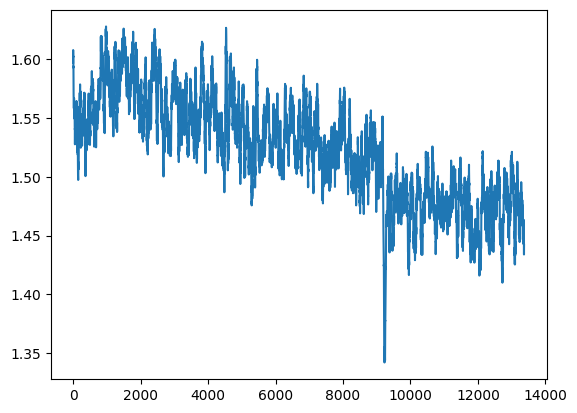

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
test_sentence = "What would you like to eat for dinner today ?"
print('Raw input text:', test_sentence)

input_ids = encode_input_string(
    text = test_sentence,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
input_ids = input_ids.unsqueeze(0).cuda()
# input_ids = input_ids.unsqueeze(0)

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: What would you like to eat for dinner today ?
Truncated input text: What would you like to eat for dinner today ?</s><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, max_new_tokens=20)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

आज तुम्हाला जेवणासाठी काय खाण्याची आवश् यकता आहे?
आज जेवणासाठी तुम्हाला काय खाण्याची आवश् यकता आहे?
आज जेवणासाठी तुम्ही काय खाऊ इच्छितो?
